In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")

In [3]:
import torch.optim as optim
from torch.utils import data

## Connected Metric

In [4]:
class ConnectedClassifier_Distance(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.zeros(1, num_sets))
        
        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim)+self.bias ### correction to make diagonal of unit square 1 in nD space
        dists = dists*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
        self.cls_confidence = x.data.cpu()
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

    def set_centroid_to_data_randomly(self, xx_, yy_, model):
        num_centers = self.centers.shape[0]
        yout = model(xx_.to(device)).data.cpu()
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy_[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.randn(self.num_sets, self.output_dim)
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 5
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass
    
    def set_new_centroid_to_input(self, x, y, bias, model):
        assert x.shape[0] == bias.shape[-1], 'New centroid size and bias size mismatch'
        assert x.shape[0] == y.shape[-1], 'New centroid size and bias size mismatch'
        
        z_ = model(x.to(self.centers.device))
        
        centers = torch.cat([self.centers.data, z_], dim=0)
        del self.centers
        self.centers = nn.Parameter(centers)
        
        bias = torch.cat([self.bias.data, bias.reshape(1, -1).to(self.centers.device)], dim=1)
        del self.bias
        self.bias = nn.Parameter(bias)
        
        init_val = torch.randn(x.shape[0], self.output_dim)
        for ns in range(init_val.shape[0]):
            init_val[ns, y[ns]] = 5
            
        cls_weight = torch.cat([self.cls_weight.data, init_val.to(self.cls_weight.device)])
        del self.cls_weight
        self.cls_weight = nn.Parameter(cls_weight)
        
        self.num_sets = self.centers.shape[0]
        
        print(self.centers.shape, self.bias.shape, self.cls_weight.shape)
        return
        
    def remove_centroid_index(self, indices):
        mask = torch.ones(self.centers.shape[0], dtype=torch.bool)
        mask[indices] = False
        indices = torch.nonzero(mask).reshape(-1)
#         print(indices)
        
        centers = self.centers.data[indices]
        del self.centers
        self.centers = nn.Parameter(centers)
        
        bias = self.bias.data[:, indices]
        del self.bias
        self.bias = nn.Parameter(bias)
        
        cls_weight = self.cls_weight.data[indices]
        del self.cls_weight
        self.cls_weight = nn.Parameter(cls_weight)
        
        print(self.centers.shape, self.bias.shape, self.cls_weight.shape)
        return

In [5]:
c = ConnectedClassifier_Distance(2, 6, 3).to(device)

In [6]:
c.remove_centroid_index(torch.LongTensor([0]))

torch.Size([5, 2]) torch.Size([1, 5]) torch.Size([5, 3])


In [7]:
c.cls_weight.shape

torch.Size([5, 3])

In [8]:
c(torch.randn(1, 2).to(device))

tensor([[1.2208, 2.0899, 1.8815]], device='cuda:0', grad_fn=<MmBackward0>)

In [9]:
c.set_new_centroid_to_input(
    torch.Tensor([[0, 0],]), 
    torch.LongTensor([1,]), 
    torch.Tensor([[0],]), 
    nn.Identity().to(device))

torch.Size([6, 2]) torch.Size([1, 6]) torch.Size([6, 3])


In [10]:
c.cls_weight.shape, c.bias.shape, c.centers.shape

(torch.Size([6, 3]), torch.Size([1, 6]), torch.Size([6, 2]))

In [11]:
c(torch.randn(1, 2).to(device))

tensor([[1.2039, 2.2635, 1.2075]], device='cuda:0', grad_fn=<MmBackward0>)

In [12]:
# asdfadsf

## Test on toy classification

In [13]:
from sklearn import datasets

In [14]:
seed = 249
np.random.seed(seed)
random.seed(seed)
torch.random.manual_seed(seed)

In [15]:
xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [16]:
xx_, y_ = datasets.make_blobs(n_samples=100, 
                              n_features=2, 
                              centers=np.array([[-1,-1], [-1, 1]]), 
                              cluster_std=0.1)

In [17]:
xx_.shape, y_.shape

((100, 2), (100,))

In [18]:
xx = np.concatenate((xx, xx_), axis=0)
y = np.concatenate((y, y_), axis=0)

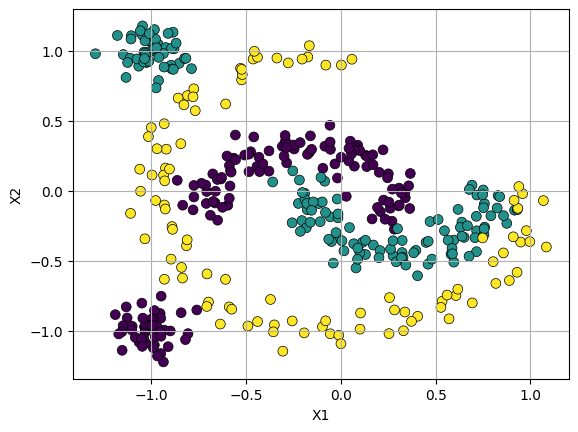

In [19]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [20]:
ycls = yy.reshape(-1).type(torch.long)

## Test using multi-invex classifier

In [21]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.res_flow as irf

In [22]:
# actf = irf.Swish
actf = irf.LeakyReLU
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [20, 20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20, 20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20, 20], activation=actf),
    ActNorm(2),
        ]

model = SequentialFlow(flows).to(device)
# model = nn.Identity().to(device)

In [23]:
classifier = ConnectedClassifier_Distance(2, 5, 3).to(device) # 8 works for invex
# classifier = nn.Linear(2, 3).to(device)

In [24]:
# classifier.set_centroid_to_data_randomly(xx, ycls, model)

In [25]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.0031)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1582


In [26]:
xx = xx.to(device)
ycls = ycls.to(device)

In [27]:
epoch = 0

## Visualize change

In [28]:
def visualize_model():
    fig = plt.figure(figsize=(12, 6))
    ax, ax_ = fig.subplots(1, 2)

    with torch.no_grad():
        yout = classifier(model(xx))

    acc = (yout.data.argmax(dim=1) == ycls)
    acc = float(acc.type(torch.float32).mean())
    losses.append(float(loss))
    print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        yout_img = classifier(model(xyg), hard=True)
        out = yout_img.data.argmax(dim=1).cpu().numpy()

    acc = (yout.data.argmax(dim=1) == ycls)
    acc = float(acc.type(torch.float32).mean())
    losses.append(float(loss))
    print(f"\t\t Hard Accuracy: {acc}")


    ax.clear(); ax_.clear()
    cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                     alpha=0.5, antialiased=True)

    ax.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
    ax.grid()


    cf = ax_.contourf(xg, yg, classifier.cls_confidence.data.argmax(dim=1).cpu().numpy().reshape(xg.shape),
                     alpha=0.9, antialiased=True, levels=classifier.num_sets, cmap='tab20')
    ### plot centers
    ## centers in input space 
    centers =  classifier.centers.data
    if isinstance(model, SequentialFlow):
        with torch.no_grad():
            centers = model.inverse(centers)
    centers = centers.cpu()
    ax_.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
    ax_.scatter(centers[:,0], centers[:,1], c=classifier.bias.data.cpu()[0,:], s=100, edgecolors='w', marker='*')
    plt.grid()

    fig.canvas.draw()
    plt.show()

In [29]:
save_indx = -1
def save_visualization(filename=None):
    global save_indx
    save_indx += 1
    
    plt.figure(figsize=(6, 6))

    with torch.no_grad():
        yout = classifier(model(xx))

    acc = (yout.data.argmax(dim=1) == ycls)
    acc = float(acc.type(torch.float32).mean())
    losses.append(float(loss))
    print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        yout_img = classifier(model(xyg), hard=True)
        out = yout_img.data.argmax(dim=1).cpu().numpy()

    acc = (yout.data.argmax(dim=1) == ycls)
    acc = float(acc.type(torch.float32).mean())
    losses.append(float(loss))
    print(f"\t\t Hard Accuracy: {acc}")

    cf = plt.contourf(xg, yg, out.reshape(xg.shape),# v,
                     alpha=0.5, antialiased=True)

    plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
    plt.grid()
    if filename is None:
        filename=f"plt_{save_indx}"
    plt.savefig(f"./invex_out/network_morphing/{filename}_A.pdf", bbox_inches='tight')
    plt.close()
    
    
    plt.figure(figsize=(6, 6))
    cf = plt.contourf(xg, yg, classifier.cls_confidence.data.argmax(dim=1).cpu().numpy().reshape(xg.shape),
                     alpha=0.9, antialiased=True, levels=classifier.num_sets, cmap='tab20')
    ### plot centers
    ## centers in input space 
    centers =  classifier.centers.data
    if isinstance(model, SequentialFlow):
        with torch.no_grad():
            centers = model.inverse(centers)
    centers = centers.cpu()
    plt.scatter(x1, x2, c=ycls.cpu().numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
    plt.scatter(centers[:,0], centers[:,1], c=classifier.bias.data.cpu()[0,:], s=100, edgecolors='w', marker='*')
    
    plt.grid()
    plt.savefig(f"./invex_out/network_morphing/{filename}_B.pdf", bbox_inches='tight')
    plt.close()

## Train

 48%|███████████████████████▌                         | 482/1000 [00:02<00:02, 210.32it/s]

Epoch: 4499 Loss: 0.022878093644976616 Accuracy: 0.9899999499320984
		 Hard Accuracy: 0.9899999499320984


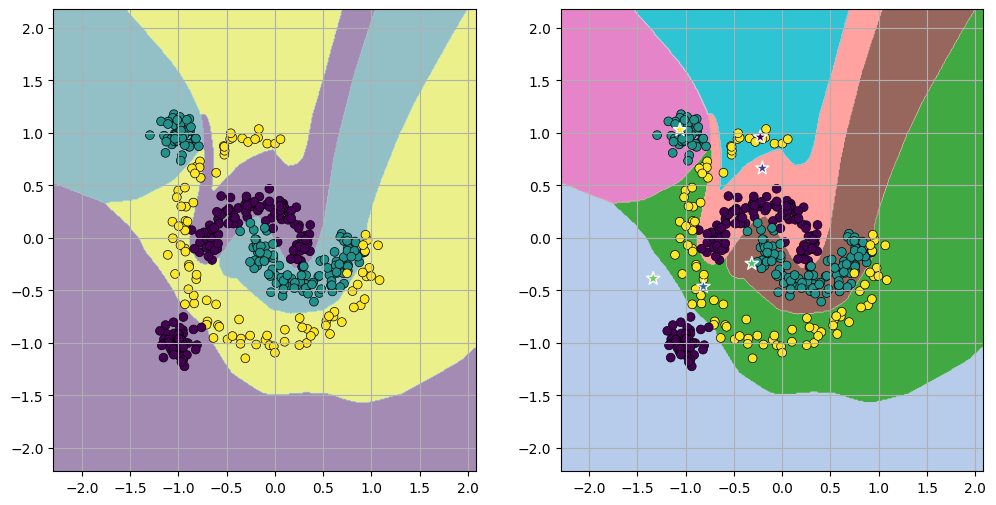

 99%|████████████████████████████████████████████████▋| 994/1000 [00:05<00:00, 211.25it/s]

Epoch: 4999 Loss: 0.025876484811306 Accuracy: 0.9899999499320984
		 Hard Accuracy: 0.98499995470047


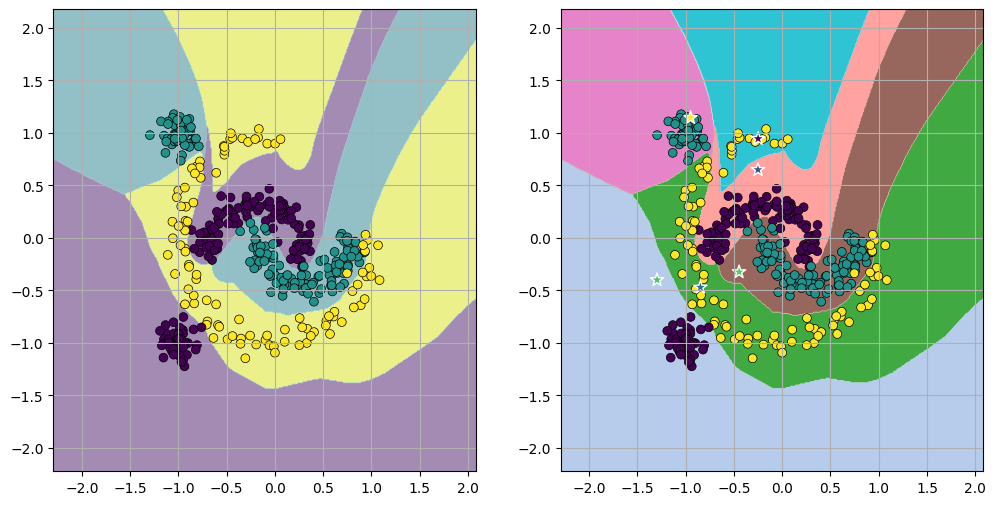

100%|████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.18it/s]


In [70]:
# %matplotlib inline
# fig = plt.figure(figsize=(12, 6))
# ax, ax_ = fig.subplots(1, 2)

losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
# _a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
s = 1.0
_a,_b,_c,_d = x1.min()-s, x1.max()+s, x2.min()-s, x2.max()+s
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg).to(device)

for steps in tqdm(range(1000)):
    epoch += 1
    optimizer.zero_grad()
    
    if epoch < 500:
        with torch.no_grad():
            tmp_ = model(xx)
            classifier.bias *= 0.
    else:
        tmp_ = model(xx)
#     classifier.bias.data *= 0.
    yout = classifier(tmp_)
    
    loss = criterion(yout, ycls)
    loss.backward()
    optimizer.step()
        
    if (epoch+1)%500 == 0:
        visualize_model()

Epoch: 5000 Loss: 0.025838052853941917 Accuracy: 0.9899999499320984
		 Hard Accuracy: 0.98499995470047


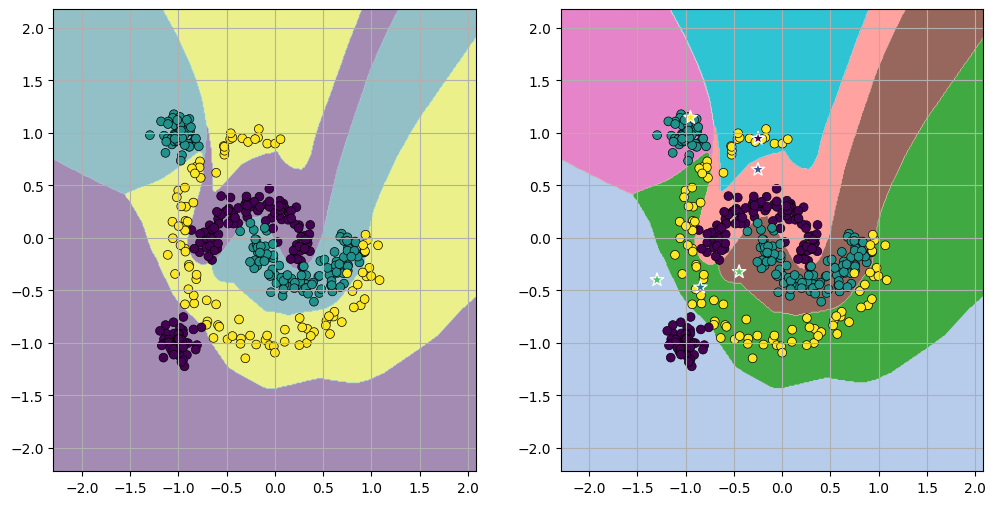

In [71]:
visualize_model()

In [32]:
This line breaks the run to allow for manual execution
Please run the addition, removal and finetuening of neurons manually

SyntaxError: invalid syntax (2728412798.py, line 1)

In [33]:
# !mkdir ./invex_out/network_morphing/

In [72]:
# save_visualization("a0_initial_training")
save_visualization("a6_finetune")

Epoch: 5000 Loss: 0.025838052853941917 Accuracy: 0.9899999499320984
		 Hard Accuracy: 0.98499995470047


In [61]:
## plot class color
np.unique(yy)

array([0., 1., 2.], dtype=float32)

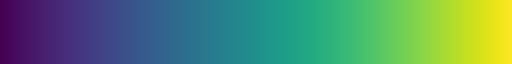

In [62]:
matplotlib.cm.viridis ## blue is 0, green is 1 and yellow is 2

## Modify the network

In [63]:
with torch.no_grad():
    if isinstance(model, SequentialFlow):
        xc = model.inverse(classifier.centers)
    else:
        xc = classifier.centers
xc

tensor([[-1.3654, -0.3920],
        [-0.1986,  0.1492],
        [-0.7613, -0.4973],
        [-0.1660,  0.4914],
        [-0.2696, -0.3845],
        [-1.0724,  1.0325],
        [-0.2120,  0.8203]], device='cuda:0')

In [64]:
xc.shape

torch.Size([7, 2])

#### To remove run this

In [65]:
# [-0.1986,  0.1492], -> 1

In [66]:
cidx = 1
classifier.remove_centroid_index(torch.LongTensor([cidx]))
del xc

torch.Size([6, 2]) torch.Size([1, 6]) torch.Size([6, 3])


#### To add run this

In [52]:
# x, y, b = (-1, 1) , 1 , 0.0
# x, y, b = (-0.55, 0.9) , 2 , 0.0
x, y, b = (-0.55, 0.9) , 2 , 0.0
classifier.set_new_centroid_to_input(
    x=torch.Tensor([x,]), 
    y=torch.LongTensor([y,]), 
    bias=torch.Tensor([[b],]), 
    model=model)

torch.Size([7, 2]) torch.Size([1, 7]) torch.Size([7, 3])


### Visualize again -> need finetune ?

Epoch: 4000 Loss: 0.025296511128544807 Accuracy: 0.9549999833106995
		 Hard Accuracy: 0.9524999856948853


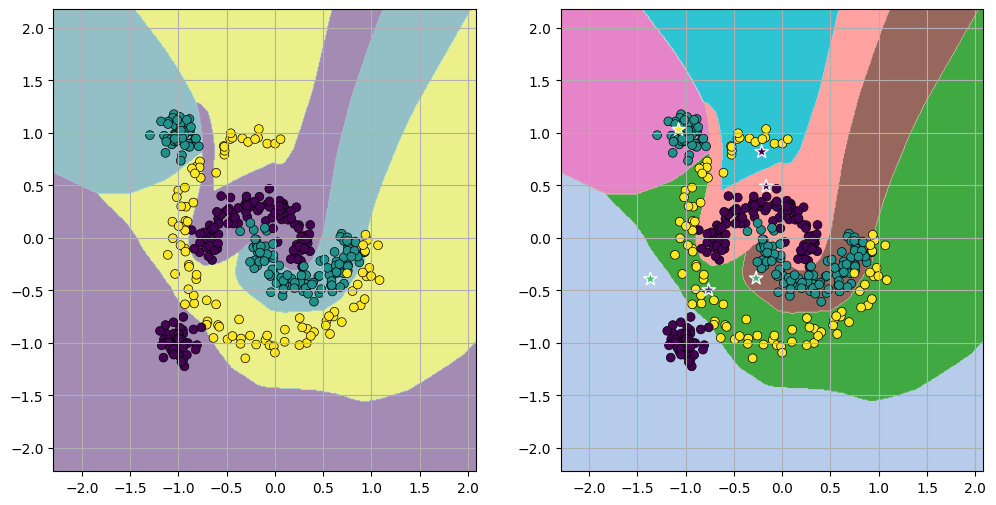

In [67]:
visualize_model()

In [68]:
save_visualization("a5_remove_center_c1")

Epoch: 4000 Loss: 0.025296511128544807 Accuracy: 0.9549999833106995
		 Hard Accuracy: 0.9524999856948853


## Reset optimizer to train to morphed network

In [69]:
optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.0031)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1582


In [ ]:
model